# Classical MLP Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

2023-03-04 18:39:44.785575: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 18:39:44.785598: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-04 18:39:45.351881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 18:39:45.351953: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-04 18:39:45.351962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

## Load the data

In [2]:
data = pd.read_csv('./data/ssdp_flood/SSDP_Flood_dataset.csv', index_col=0, dtype=np.float32)

In [3]:
labels = pd.read_csv('./data/ssdp_flood/SSDP_Flood_labels.csv', index_col=0, dtype=np.int32)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4077265 entries, 1.997161626815796 to 7431.08154296875
Columns: 114 entries, 2.090000000000000000e+02 to 0.000000000000000000e+00.54
dtypes: float32(114)
memory usage: 1.8 GB


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4077266 entries, 1 to 4077266
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   x       int32
dtypes: int32(1)
memory usage: 46.7 MB


In [6]:
data.head(5)

,2.090000000000000000e+02,0.000000000000000000e+00,1.000000000000000000e+00.1,2.090000000000000000e+02.1,0.000000000000000000e+00.1,1.000000000000000000e+00.2,2.090000000000000000e+02.2,0.000000000000000000e+00.2,1.000000000000000000e+00.3,2.090000000000000000e+02.3,...,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,1.000000000000000000e+00.24,2.090000000000000000e+02.28,0.000000000000000000e+00.51,2.090000000000000000e+02.29,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54
1.000000000000000000e+00,,,,,,,,,,,,,,,,,,,,,
1.997162,830.381897,385019.46875,1.998296,830.029114,385019.96875,1.999432,829.676392,385020.21875,1.999943,829.517639,...,0.000000e+00,0.0,0.0,1.000000,1450.000000,0.000000,1450.000000,0.000000e+00,0.0,0.0
2.996940,586.005371,375805.68750,2.998163,585.869934,375719.28125,2.999388,585.734436,375632.81250,2.999939,585.673462,...,3.080250e+03,0.0,0.0,1.999994,153.499832,55.500000,153.499832,3.080250e+03,0.0,0.0
3.994740,802.288452,421819.59375,3.996842,802.073120,421799.12500,3.998947,801.857727,421778.53125,3.999895,801.760803,...,0.000000e+00,0.0,0.0,1.999998,1450.000000,0.000022,1450.000000,4.656613e-10,0.0,0.0
4.994129,661.265198,416790.00000,4.996476,661.159180,416736.78125,4.998825,661.053101,416683.46875,4.999882,661.005310,...,2.737938e+03,0.0,0.0,2.999990,134.999832,52.325844,134.999832,2.737994e+03,0.0,0.0
5.991415,792.909363,433727.62500,5.994846,792.745667,433706.71875,5.998281,792.581909,433685.75000,5.999828,792.508179,...,4.656613e-10,0.0,0.0,2.999995,1450.000000,0.000022,1450.000000,4.656613e-10,0.0,0.0


In [7]:
labels.head(5)

,x
1,0
2,0
3,0
4,0
5,0


In [8]:
data.describe()

,2.090000000000000000e+02,0.000000000000000000e+00,1.000000000000000000e+00.1,2.090000000000000000e+02.1,0.000000000000000000e+00.1,1.000000000000000000e+00.2,2.090000000000000000e+02.2,0.000000000000000000e+00.2,1.000000000000000000e+00.3,2.090000000000000000e+02.3,...,0.000000000000000000e+00.48,0.000000000000000000e+00.49,0.000000000000000000e+00.50,1.000000000000000000e+00.24,2.090000000000000000e+02.28,0.000000000000000000e+00.51,2.090000000000000000e+02.29,0.000000000000000000e+00.52,0.000000000000000000e+00.53,0.000000000000000000e+00.54
count,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,...,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06
mean,5.554439e+02,2.108595e+05,4.355221e+03,5.557676e+02,2.108744e+05,1.276560e+04,5.561489e+02,2.108758e+05,9.853343e+04,5.567278e+02,...,2.580109e+04,2.071431e-06,6.001112e-09,1.221561e+04,5.586177e+02,9.349367e+01,6.280416e+02,2.556148e+04,1.726344e-03,9.115259e-07
std,4.092351e+02,2.086144e+05,5.746313e+03,4.091264e+02,2.083395e+05,1.695074e+04,4.090779e+02,2.081008e+05,1.389378e+05,4.089505e+02,...,3.552620e+04,1.730315e-03,4.300500e-06,1.044919e+04,5.968528e+02,1.203566e+02,6.119583e+02,3.282316e+04,1.188072e+00,6.337396e-04
min,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,1.000000e+00,6.000000e+01,...,0.000000e+00,-4.037125e-11,-1.693859e-07,1.000000e+00,6.000000e+01,0.000000e+00,6.000000e+01,0.000000e+00,-5.179450e-11,-3.526279e-07
25%,1.360000e+02,1.091394e-10,1.075302e+02,1.360000e+02,1.455192e-10,2.865569e+02,1.360000e+02,3.819878e-10,2.716526e+03,1.360000e+02,...,3.637979e-12,0.000000e+00,0.000000e+00,1.421469e+01,1.360000e+02,1.907349e-06,1.360000e+02,3.637979e-12,0.000000e+00,0.000000e+00
50%,7.109297e+02,6.919059e+04,1.862831e+02,7.144795e+02,6.353470e+04,5.609031e+02,7.185513e+02,5.612514e+04,5.557169e+03,7.203674e+02,...,7.450581e-09,0.000000e+00,0.000000e+00,1.270956e+04,1.619071e+02,1.181941e-04,1.996456e+02,2.328306e-08,0.000000e+00,0.000000e+00
75%,7.403090e+02,4.303227e+05,1.226076e+04,7.394688e+02,4.313373e+05,3.673085e+04,7.385090e+02,4.324128e+05,2.506288e+05,7.392285e+02,...,4.584004e+04,0.000000e+00,0.000000e+00,2.283273e+04,1.401286e+03,2.116107e+02,1.403627e+03,4.542045e+04,0.000000e+00,0.000000e+00
max,1.443829e+03,4.514164e+05,1.241180e+04,1.437632e+03,4.486328e+05,3.717351e+04,1.424138e+03,4.483268e+05,3.540998e+05,1.415310e+03,...,4.571445e+05,2.523574e+00,3.828065e-03,2.700766e+04,1.450000e+03,5.926365e+02,1.450000e+03,3.512180e+05,1.080780e+03,5.609915e-01


## Scale the data

In [9]:
# scale the data
scaler = pp.MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
count,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,...,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06,4.077265e+06
mean,3.580238e-01,4.671063e-01,3.508413e-01,3.598694e-01,4.700377e-01,3.433883e-01,3.637087e-01,4.703622e-01,2.782625e-01,3.665047e-01,...,5.643966e-02,8.208480e-07,4.581425e-05,4.522811e-01,3.587175e-01,1.577588e-01,4.086633e-01,7.277953e-02,1.597313e-06,2.253427e-06
std,2.957265e-01,4.621330e-01,4.630089e-01,2.969780e-01,4.643876e-01,4.560021e-01,2.998802e-01,4.641721e-01,3.923702e-01,3.017395e-01,...,7.771327e-02,6.856606e-04,1.123364e-03,3.869117e-01,4.293905e-01,2.030867e-01,4.402577e-01,9.345526e-02,1.099273e-03,1.129677e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.492007e-02,2.417709e-16,8.583670e-03,5.516712e-02,3.243613e-16,7.681936e-03,5.571285e-02,8.520296e-16,7.668835e-03,5.607574e-02,...,7.958050e-18,1.599765e-11,4.424648e-05,4.893123e-04,5.467626e-02,3.218412e-09,5.467626e-02,1.035818e-17,4.792328e-14,6.285793e-07
50%,4.703829e-01,1.532744e-01,1.492918e-02,4.750757e-01,1.416185e-01,1.506229e-02,4.827601e-01,1.251880e-01,1.569101e-02,4.872446e-01,...,1.629809e-14,1.599765e-11,4.424648e-05,4.705715e-01,7.331443e-02,1.994377e-07,1.004644e-01,6.629234e-14,4.792328e-14,6.285793e-07
75%,4.916134e-01,9.532721e-01,9.878299e-01,4.932150e-01,9.614484e-01,9.880919e-01,4.973904e-01,9.645034e-01,7.077904e-01,5.011610e-01,...,1.002747e-01,1.599765e-11,4.424648e-05,8.454109e-01,9.649540e-01,3.570667e-01,9.666380e-01,1.293227e-01,4.792328e-14,6.285793e-07
max,1.000000e+00,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999999e-01,...,1.000000e+00,1.000000e+00,9.999999e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Train-Test Split

In [10]:
# drop the last row
labels=labels[:-1]
labels.tail(5)

,x
4077261,1
4077262,1
4077263,1
4077264,1
4077265,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=False, test_size=0.3)

In [12]:
print(f'Number anomalies in train data: {y_train.sum()}')

Number anomalies in train data: x    229441
dtype: int64


In [13]:
print(f'Number anomalies in test data: {y_test.sum()}')

Number anomalies in test data: x    1210162
dtype: int64


## Define MLP

In [14]:
# model parameters
n_input = X_train.shape[1]
n_hidden = 64 # number neurons in the hidden layer

In [15]:
def mlp(n_input, n_hidden, lr=0.001):
    # define layers
    inputs = tf.keras.Input(shape=(n_input,))
    dense1 = tf.keras.layers.Dense(n_hidden, activation='relu')
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')
    layers = [inputs, dense1, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=[rmse, mae])
    return model

## Train MLP

In [16]:
model = mlp(n_input, n_hidden, lr=0.0001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7360      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 7,425
Trainable params: 7,425
Non-trainable params: 0
_________________________________________________________________


2023-03-04 18:41:49.625068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 18:41:49.625304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 18:41:49.626111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-04 18:41:49.626185: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-04 18:41:49.626255: W tensorflow/c

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=20,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=10000,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping],
                    verbose=1)

2023-03-04 18:41:52.338858: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1301462760 exceeds 10% of free system memory.


Epoch 1/100
284/286 [============================>.] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.1768 - mean_absolute_error: 0.1392

2023-03-04 18:41:56.665227: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 557770080 exceeds 10% of free system memory.


286/286 [==============================] - 4s 10ms/step - loss: 0.0311 - root_mean_squared_error: 0.1765 - mean_absolute_error: 0.1388 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1630 - val_mean_absolute_error: 0.1359
Epoch 2/100
286/286 [==============================] - 2s 8ms/step - loss: 0.0052 - root_mean_squared_error: 0.0723 - mean_absolute_error: 0.0424 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237 - val_mean_absolute_error: 0.0649
Epoch 3/100
286/286 [==============================] - 2s 8ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0230 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181 - val_mean_absolute_error: 0.0440
Epoch 4/100
286/286 [==============================] - 2s 8ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - mean_absolute_error: 0.0166 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1169 - val_mean_absolute_error: 0.0352
Epoch 5/100
286/286 [==============================] - 2s 8ms/s

Minimal Loss: 0.0100


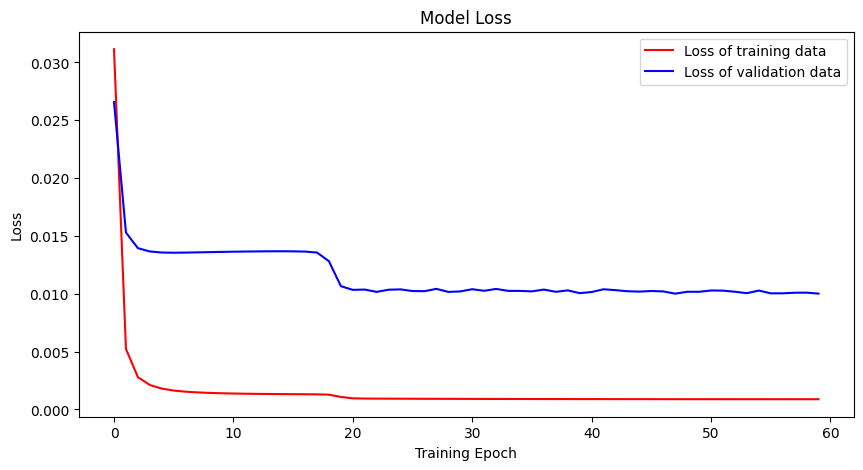

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_loss = min(val_loss)
print(f'Minimal Loss: {min_loss:.4f}')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## Evaluate MLP

In [19]:
predictions = model.predict(X_test, verbose=1)

    1/38225 [..............................] - ETA: 1:24:08

2023-03-04 18:44:08.054396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 557770080 exceeds 10% of free system memory.


38225/38225 [==============================] - 36s 932us/step


In [20]:
# average precision score train
aps_test = average_precision_score(y_test, predictions)
print(f'Average precision score for test: {aps_test:.4f}')

Average precision score for test: 0.9941


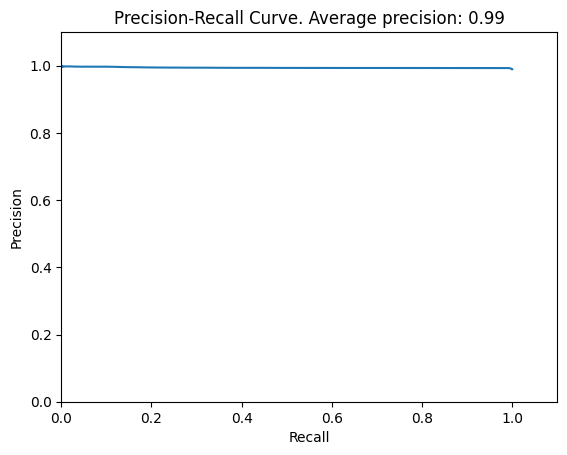

In [21]:
# precision-recall curve for test results
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
plt.title(f'Precision-Recall Curve. Average precision: {aps_test:.2f}')
plt.xlabel('Recall')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Precision')
#plt.ylim([0, 1.1])
#plt.xlim([0, 1.0])
plt.plot(recall, precision)
plt.show()

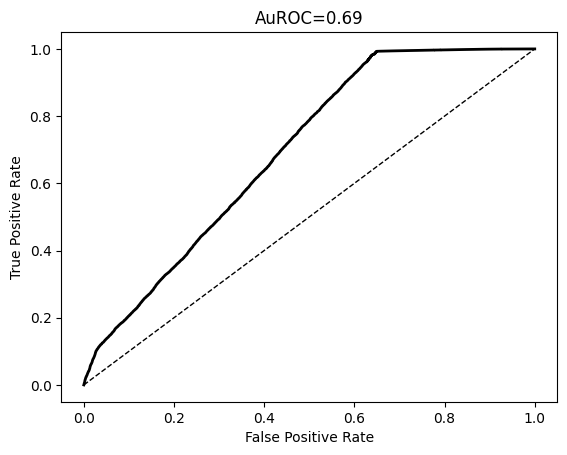

In [23]:
# receiver operational characteristic
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auROC = auc(fpr, tpr)
plt.figure()
plt.title(f'AuROC={auROC:.2f}')
plt.plot(fpr, tpr, color='k', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], color='k', lw=1, linestyle='--')
plt.savefig('AuROC_MLP.png')
plt.show()